# Putting together chunks for preprocessing
1. Use ```glob``` to find all the chunks
2. Run this pipeline for multidataset integration: https://chanzuckerberg.github.io/cellxgene-census/notebooks/analysis_demo/comp_bio_data_integration_scvi.html
2. Run PCA to get ```X_pca``` layer of the data

# Steps prior to generating the UMAP
1. Normalization
- The CZI data normalises to a sum of 1e1, but the integration procedure uses 1e4. Since there are raw counts available in the data, going ahead with the target sum 1e4 makes more sense. 
2. log1p transformation
3. Scaling



In [1]:
import cellxgene_census
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import os
from IPython.display import display # easy viewing of dataframes
import glob
from pathlib import Path
import harmonypy
import matplotlib as plt
from scipy.sparse import csr_matrix
import scvi 

In [ ]:
# chunk_datapath = Path("../data/cellxgene_data") # set datapath
# chunk_files = glob.glob(str(chunk_datapath) + "/*.h5ad")  # use glob to find all the .h5ad files

# # Read all files into a list
# adata_list = [sc.read_h5ad(f) for f in chunk_files] 
# adata = anndata.concat(adata_list, merge="same") # concatenate adata

# # Set new column batch based on dataset ID
# adata.obs["batch"] = adata.obs["dataset_id"].astype(str)  # Ensure it's a string

# adata.write("../data/datasets/cellxgene_covid_pbmc.h5ad")
# # Restart kernel at this point

In [ ]:
# Check for batch induced clustering
covid_data_read = sc.read_h5ad("../data/datasets/cellxgene_covid_pbmc.h5ad")
del covid_data_read.obsm["X_pca"]

In [ ]:
np.median(covid_data_read.layers["normalized"].sum(axis=1))

In [ ]:
sc.pp.neighbors(covid_data_read) # compute neighbors
sc.tl.umap(covid_data_read) # compute UMAP - takes ~67 mins

In [2]:
test_chunk = sc.read_h5ad("../data/cellxgene_data/covid_PBMC_chunk0.h5ad")
test_chunk.layers["counts"] = test_chunk.X.copy()

In [3]:
sc.pp.normalize_total(test_chunk, target_sum=1e4)
sc.pp.log1p(test_chunk)
sc.pp.scale(test_chunk, max_value=10)

sc.pp.highly_variable_genes(
    test_chunk,
    n_top_genes=2000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="dataset_id",
    subset=True,
)

sc.pp.pca(test_chunk)
sc.pp.neighbors(test_chunk, n_neighbors=10, n_pcs=40)

sc.tl.umap(test_chunk)

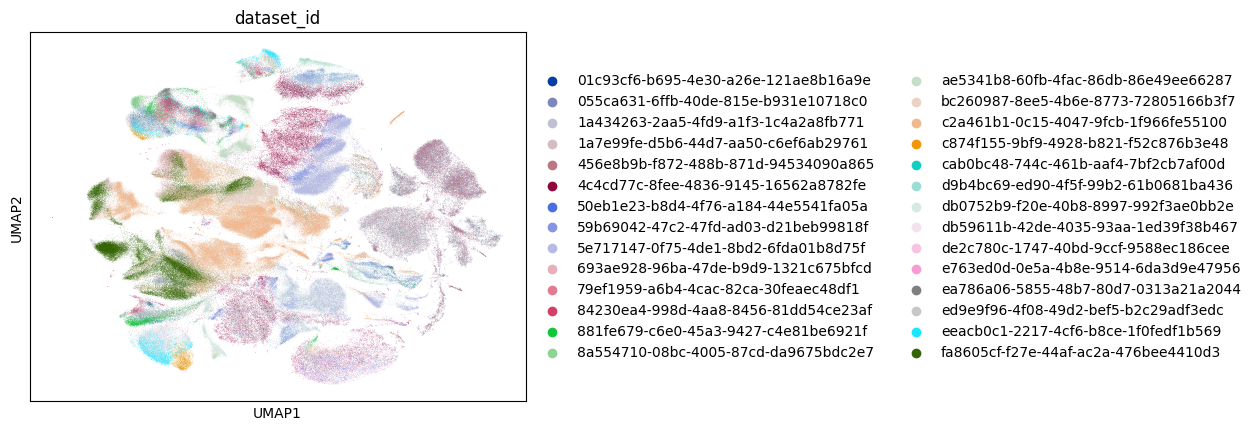

In [4]:
sc.pl.umap(test_chunk, color="dataset_id")

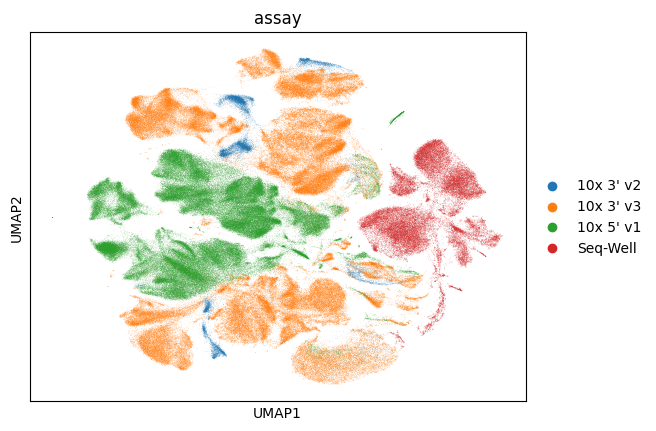

In [6]:
sc.pl.umap(test_chunk, color="assay")

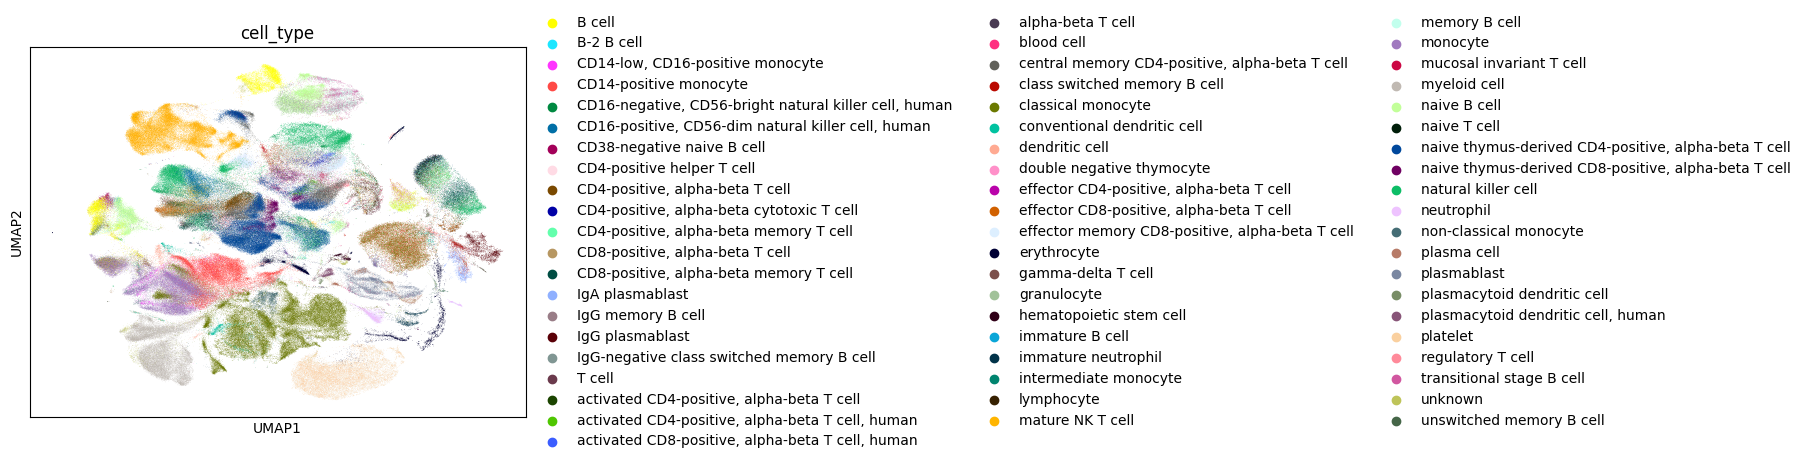

In [5]:
sc.pl.umap(test_chunk, color="cell_type")

In [7]:
scvi.model.SCVI.setup_anndata(test_chunk, layer="counts", batch_key="dataset_id")
vae = scvi.model.SCVI(test_chunk, n_layers=2, n_latent=30, gene_likelihood="nb", n_hidden=50)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
vae.train(max_epochs=100)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/s5srinivasan/immune-foundational-model/.venv/lib64/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [51:28<00:00, 30.45s/it, v_num=1, train_loss_step=723, train_loss_epoch=729]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [51:28<00:00, 30.88s/it, v_num=1, train_loss_step=723, train_loss_epoch=729]


In [11]:
test_chunk.obsm["X_scVI"] = vae.get_latent_representation()

In [17]:
print(test_chunk.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_umap, X_scVI)


In [ ]:
sc.pp.neighbors(test_chunk, use_rep="X_scVI")


In [22]:
sc.tl.umap(test_chunk)

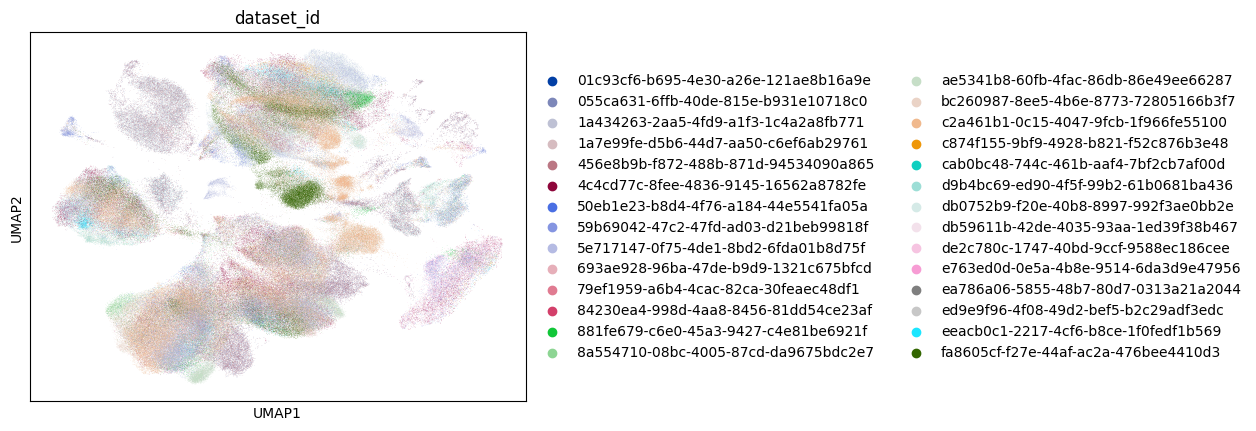

In [23]:
sc.pl.umap(test_chunk, color="dataset_id")

AttributeError: PathCollection.set() got an unexpected keyword argument 'use_rep'

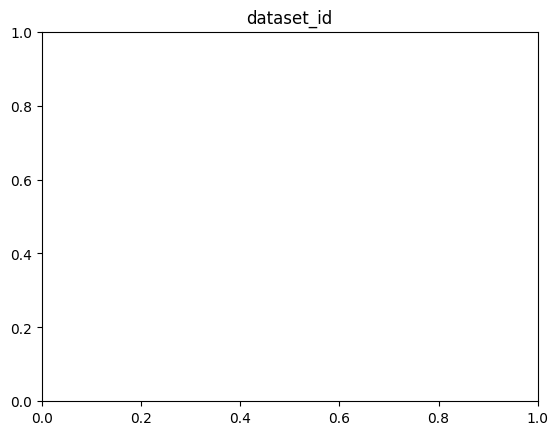

In [ ]:
sc.pl.umap(test_chunk, layer="counts",color="dataset_id")

In [24]:
test_chunk

AnnData object with n_obs × n_vars = 500000 × 2000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', '_scvi_batch', '_scvi_labels'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_id_colors', 'cell_type_colors', 'assay_colors', '_scv

In [ ]:
chunk_1 = sc.read_h5ad("../data/cellxgene_data/covid_PBMC_chunk1.h5ad")

# Total expression before normalization
cell_sums_before = np.sum(chunk_1.X, axis=1)
cell_sums_before_norm = np.sum(chunk_1.layers["normalized"], axis=1)
print("Total expression before normalization:", cell_sums_before[:10])  # Print for first 10 cells
print("Total expression before normalization (IN NORM):", cell_sums_before_norm[:10])  # Print for first 10 cells

# Normalize total expression to target_sum=1e4
sc.pp.normalize_total(chunk_1, target_sum=1)

# Total expression after normalization
cell_sums_after = np.sum(chunk_1.X, axis=1)
cell_sums_after_norm = np.sum(chunk_1.layers["normalized"], axis=1)
print("Total expression after normalization:", cell_sums_after[:10])  # Print for first 10 cells
print("Total expression after normalization (IN NORM):", cell_sums_after_norm[:10])  # Print for first 10 cells